# Prediction - Up-and-in Call Barriers

Up-and in barrier: If any future value touches the barrier, it becomes active

$$\mathbb{E}[S_{T}1_{\max \{log(S_{u}) : u \geq t \} > log(b)}]$$

Boundary condition: $S \rightarrow 0 , C \rightarrow 0 , b \rightarrow \infty, C \rightarrow 0 $, $C(S) = C^{BS}(S)$ for $S > 0$

$$V(T, b) = V^{BS}(T, s), s > b$$

Replication: Up and in + Up and out = BS Call

Closed form is given by joint density of running maximum and brownian motion

In [1]:
%run ../nn_option_pricer/key_imports.py
import sys
sys.path.append("../")
from nn_option_pricer.bs import gbm_step, bs_eval_wrapper
from nn_option_pricer.nn_archi import make_model, homogeneity_network
from nn_option_pricer.utils import visualise_surface

In [2]:
X_df = pd.read_csv("datasets/bs_barrier.csv")
feat_names = ['log(S/K)', 'ttm', 'b']
f_to_i = lambda x: feat_names.index(x)
Xs = X_df[feat_names].values
ys = X_df['barrier_call_payoff']

print("BASELINE MSE: ", np.mean((ys - ys.mean()) ** 2))
print("BASELINE MAE: ", np.mean(np.abs(ys - ys.mean())))

all_res = []

BASELINE MSE:  0.4718565358404778
BASELINE MAE:  0.3710113880261819


<AxesSubplot:xlabel='log(S/K)', ylabel='PDE_call_barrier'>

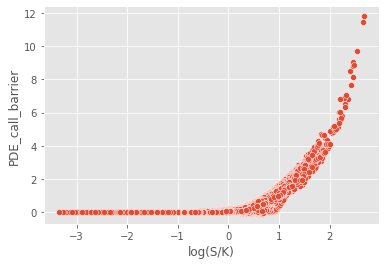

In [3]:
sns.scatterplot(X_df['log(S/K)'], X_df['PDE_call_barrier'])

<AxesSubplot:xlabel='log(S/K)', ylabel='barrier_call_payoff'>

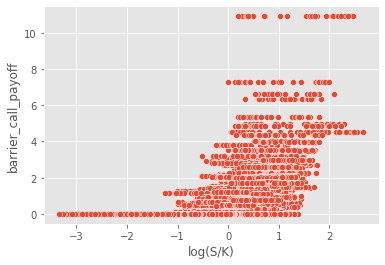

In [4]:
sns.scatterplot(X_df['log(S/K)'], X_df['barrier_call_payoff'])

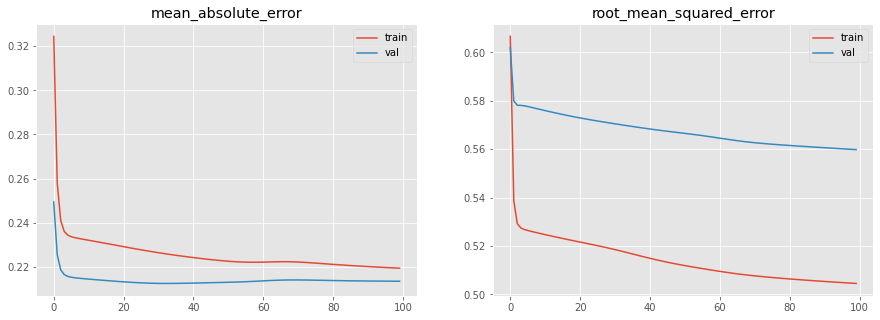

In [5]:
HIDDEN_UNITS = 256
LAYERS = 1
dropout_ratio = 0.0
HIDDEN_ACT = 'softplus'
N_FEATS = len(feat_names)
OUTPUT_ACT = 'softplus'
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 100
BATCH_NORM = False
VAL_SPLIT = 0.2
loss_fn = tf.keras.losses.MeanSquaredError()
METRICS = [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]

CALLBACKS = [EarlyStopping(patience=5)]
opt = Adam(learning_rate = LR)


ffn = make_model(N_FEATS, 
                 HIDDEN_UNITS, 
                 LAYERS, 
                 DROPOUT_RATIO, 
                 HIDDEN_ACT, 
                 OUTPUT_ACT, 
                 BATCH_NORM)


ffn.compile(optimizer=opt, loss=loss_fn, metrics = METRICS)
start = time.time()
history = ffn.fit(Xs, ys, 
                  epochs = EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_split = VAL_SPLIT,
                  shuffle=False,
                  verbose = 0,
                  callbacks=CALLBACKS)
end = time.time()

metrics = ['mean_absolute_error', 'root_mean_squared_error']
fig, ax = plt.subplots(figsize=(15, 5), ncols = 2)
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label="train")
    ax[i].plot(history.history[f"val_{metric}"], label="val")
    ax[i].legend()
    ax[i].set_title(metric)

<AxesSubplot:xlabel='log(S/K)'>

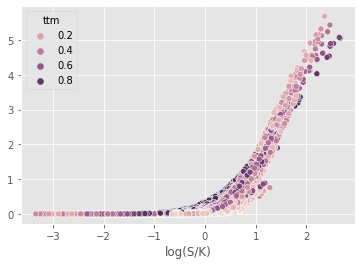

In [6]:
preds = ffn.predict(Xs).reshape(-1)
sns.scatterplot(X_df['log(S/K)'], preds, hue = X_df['ttm'])

In [7]:
true = X_df['PDE_call_barrier']
upper_bound = X_df['BS_call']
lower_bound = None

Failed to compute gradient errors


<Axes3DSubplot:title={'center':'Surface'}, xlabel='Moneyness', ylabel='ttm'>

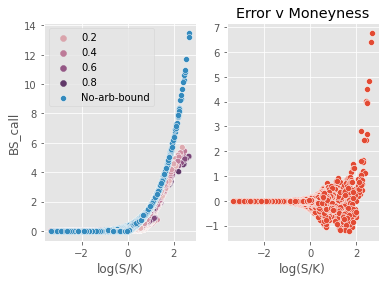

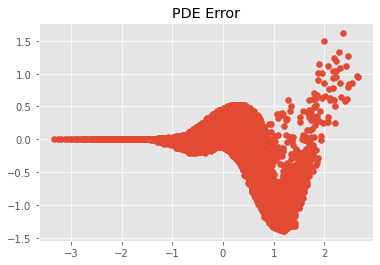

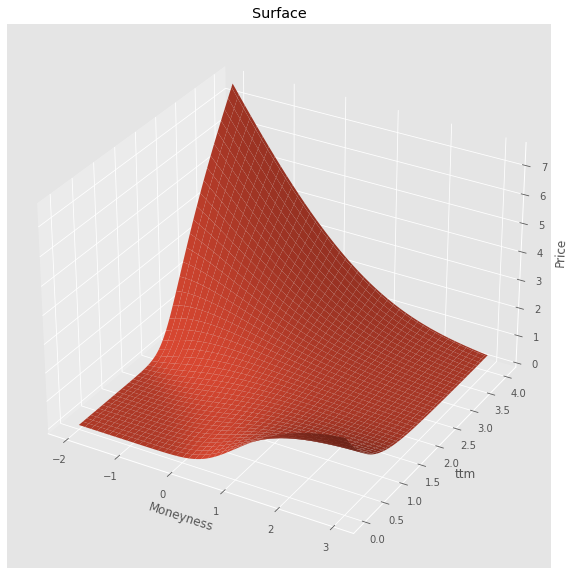

In [8]:
"""
Prediction Errors
"""
model = ffn
preds = model.predict(Xs)
try:
    preds = preds.reshape(-1)
except:
    pass

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]

temp = bs_eval_wrapper(X_df, 
                    true_val = true.values, 
                    preds = preds,
                    grads = grads,
                    hessian_moneyness = hessian_moneyness,
                    lower_bound = lower_bound, 
                    upper_bound = upper_bound,
                    METHOD = "standard_ffn"
                    )
temp['time'] = end - start

all_res += [temp.copy()]

"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128) 
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
X2 = np.zeros((X.shape[0], N_FEATS))
X2[:, :2] = X
X2[:, 2] = 0.1
visualise_surface(SK, ts, model(X2).numpy())

33.6166729927063


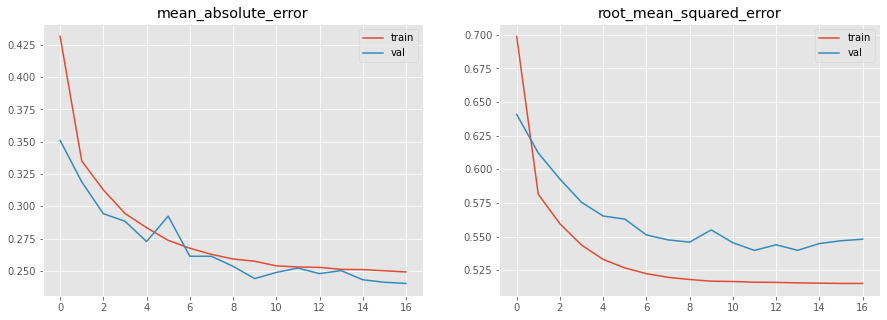

In [9]:
HIDDEN_UNITS = 256
LAYERS = 1
dropout_ratio = 0.0
HIDDEN_ACT = 'softplus'
N_FEATS = len(feat_names)
OUTPUT_ACT = 'softplus'
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 100
BATCH_NORM = False
VAL_SPLIT = 0.2
loss_fn = tf.keras.losses.MeanSquaredError()
METRICS = [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]

CALLBACKS = [EarlyStopping(patience=5)]
opt = Adam(learning_rate = LR)

gated_model = homogeneity_network(N_FEATS, HIDDEN_UNITS, seed = 42)
gated_model.compile(optimizer=opt, loss=loss_fn, metrics = METRICS)
start = time.time()
history = gated_model.fit([Xs[:,0], Xs[:,1], Xs[:,2]], 
                    ys, 
                  epochs = EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_split = VAL_SPLIT,
                  verbose = 0,
                  shuffle=True,
                  callbacks=CALLBACKS)
end = time.time()
print(end - start)

fig, ax = plt.subplots(figsize=(15, 5), ncols = 2)
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label="train")
    ax[i].plot(history.history[f"val_{metric}"], label="val")
    ax[i].legend()
    ax[i].set_title(metric)

Failed to compute gradient errors


<Axes3DSubplot:title={'center':'Surface'}, xlabel='Moneyness', ylabel='ttm'>

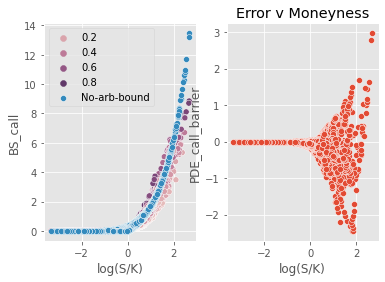

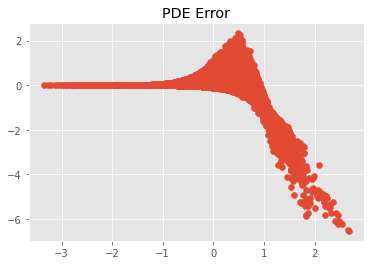

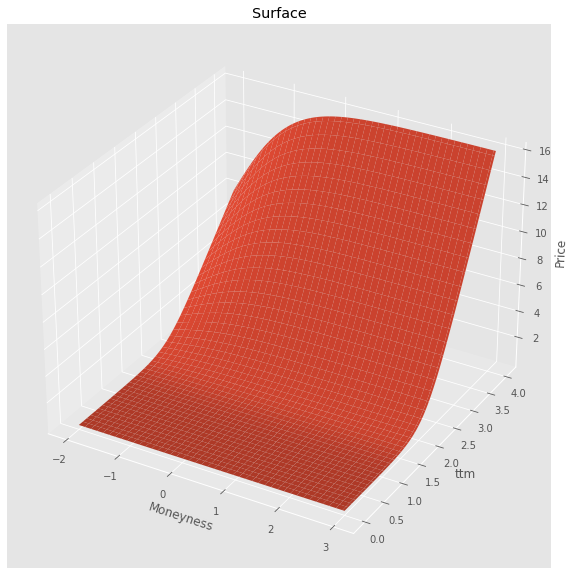

In [10]:
preds = (gated_model.predict([Xs[:,0], Xs[:,1], Xs[:,2]]).reshape(-1)).reshape(-1)

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = gated_model([X_tensor[:,0], X_tensor[:,1], X_tensor[:,2]])
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)
    
grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]
    
temp = bs_eval_wrapper(X_df, 
                    true_val = true,
                    preds = preds,
                    grads = grads,
                    hessian_moneyness = hessian_moneyness,
                    lower_bound = lower_bound, 
                    upper_bound = upper_bound,
                    METHOD = "homogeneity_network"
                    )
temp['time'] = end - start
all_res += [temp.copy()]

"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128) 
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
X2 = np.zeros((X.shape[0], N_FEATS))
X2[:, :2] = X
X2[:, 2] = 0.1
visualise_surface(SK, ts, gated_model([X2[:,0], X2[:,1], X2[:,2]]).numpy())

  0%|          | 0/100 [00:00<?, ?it/s]

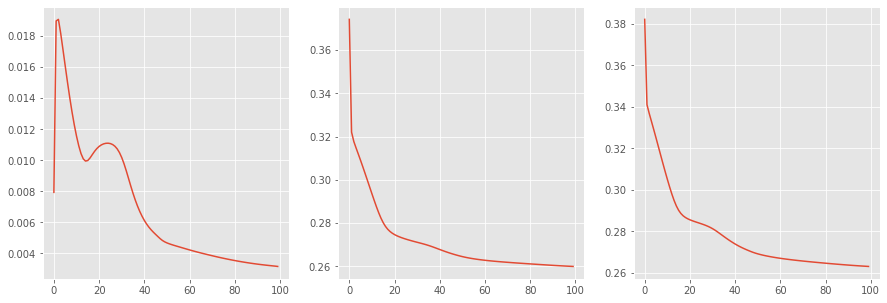

In [11]:
HIDDEN_UNITS = 256
LAYERS = 1
dropout_ratio = 0.0
HIDDEN_ACT = 'softplus'
N_FEATS = len(feat_names)
OUTPUT_ACT = 'softplus'
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 100
BATCH_NORM = False
VAL_SPLIT = 0.2
loss_fn = tf.keras.losses.MeanSquaredError()
opt = Adam(learning_rate = LR)


dataset = tf.data.Dataset.from_tensor_slices((Xs, ys))
opt = Adam(learning_rate = LR)
model = make_model(N_FEATS, 
                 HIDDEN_UNITS, 
                 LAYERS, 
                 DROPOUT_RATIO, 
                 HIDDEN_ACT, 
                 OUTPUT_ACT, 
                 BATCH_NORM)

batched_dataset = dataset.batch(BATCH_SIZE)

@tf.function
def train(y, x_var):
    with tf.GradientTape() as model_tape:
        with tf.GradientTape() as hessian_tape:
            with tf.GradientTape() as grad_tape:
                output = model(x_var)
            gradients = grad_tape.gradient(output, x_var)
            hessian = hessian_tape.gradient(gradients[:,0], x_var)
            pde_loss = tf.math.reduce_mean((gradients[:,1] + x_var[:,1] * (-hessian[:,0] + gradients[:,0])) ** 2)
            pred_loss = tf.keras.losses.MeanSquaredError()(output, y)
            loss = pde_loss + pred_loss
            model_grad = model_tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(model_grad, model.trainable_variables))
    return loss, pred_loss, pde_loss

losses = {"pde": [None for _ in range(EPOCHS)], "loss":[None for _ in range(EPOCHS)], "pred":[None for _ in range(EPOCHS)]}
start = time.time()
for epoch in tqdm(range(EPOCHS)):
    temp_pred = []
    temp_pde = []
    temp_loss = []
    for step, (x, y_true) in enumerate(batched_dataset):
        x_var = tf.Variable(x)
        loss, pred_loss, pde_loss = train(y_true, x_var)
        temp_pred += [pred_loss.numpy()]
        temp_pde += [pde_loss.numpy()]
        temp_loss += [loss.numpy()]
    losses['pde'][epoch] = np.mean(temp_pde)
    losses['pred'][epoch] = np.mean(temp_pred)
    losses['loss'][epoch] = np.mean(temp_loss)
end = time.time()

fig, ax = plt.subplots(ncols = 3, figsize=(15, 5))
ax[0].plot(losses['pde'])
ax[1].plot(losses['pred'])
ax[2].plot(losses['loss'])

Failed to compute gradient errors


<Axes3DSubplot:title={'center':'Surface'}, xlabel='Moneyness', ylabel='ttm'>

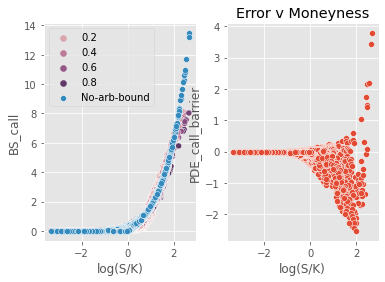

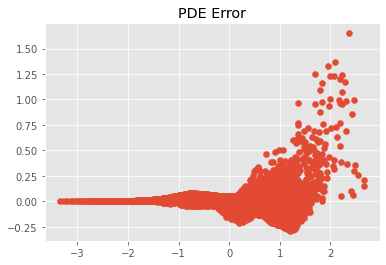

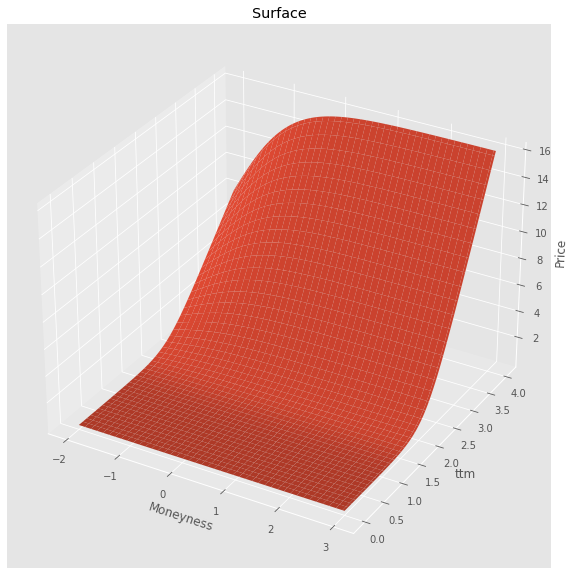

In [12]:
preds = model.predict(Xs).reshape(-1)
"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]
   
temp = bs_eval_wrapper(X_df, 
                    true_val = true,
                    preds = preds,
                    grads = grads,
                    hessian_moneyness = hessian_moneyness,
                    lower_bound = lower_bound, 
                    upper_bound = upper_bound,
                    METHOD = "ffn+PDE"
                    )
temp['time'] = end - start
all_res += [temp.copy()]

<Axes3DSubplot:title={'center':'Surface'}, xlabel='Moneyness', ylabel='ttm'>

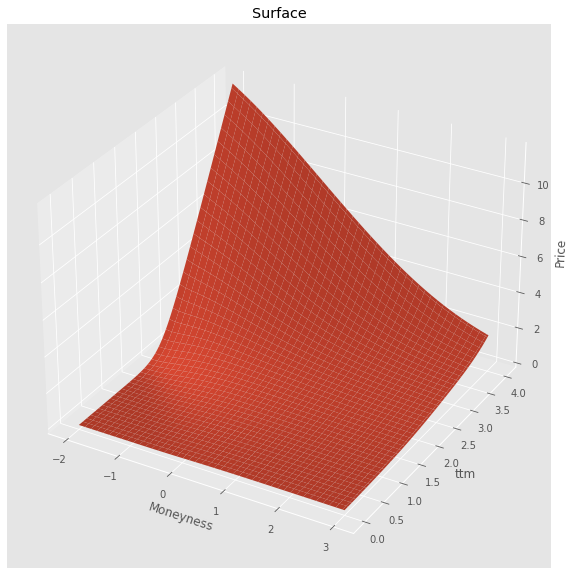

In [17]:
"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128) 
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
X2 = np.zeros((X.shape[0], N_FEATS))
X2[:, :2] = X
X2[:, 2] = 0.1
visualise_surface(SK, ts, model(X2).numpy())

Failed to compute gradient errors


AttributeError: 
        'EagerTensor' object has no attribute 'reshape'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()

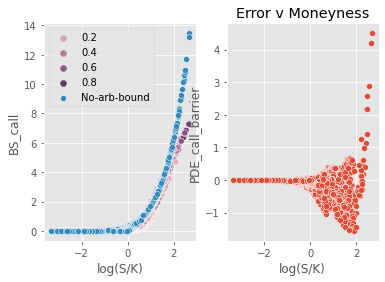

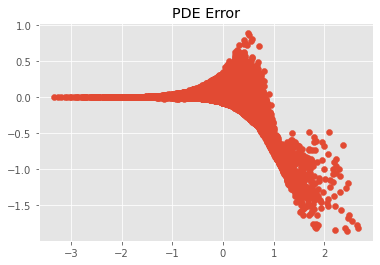

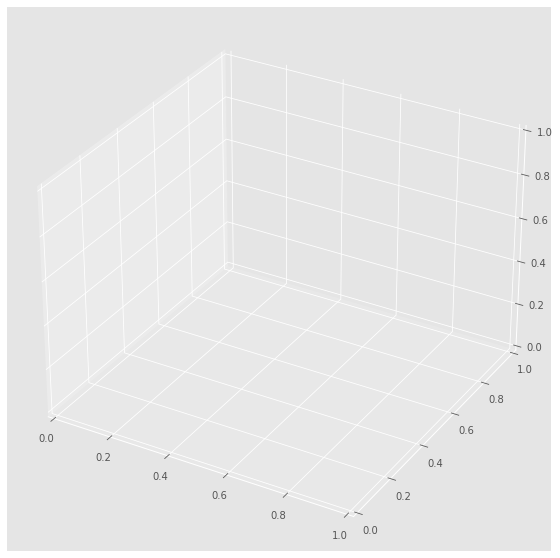

In [21]:
preds = (model.predict(Xs).reshape(-1) + ffn.predict(Xs).reshape(-1) + gated_model.predict([Xs[:,0], Xs[:,1], Xs[:,2]]).reshape(-1)) / 3
"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)
    
    
X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = ffn(X_tensor)
        grads_ffn = tape.gradient(output, X_tensor)
    hessian1_ffn = tape2.gradient(grads_ffn[:, f_to_i("log(S/K)")], X_tensor)
    
X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = gated_model([X_tensor[:,0], X_tensor[:,1], X_tensor[:,2]])
        grads_gated = tape.gradient(output, X_tensor)
    hessian1_gated = tape2.gradient(grads_gated[:, f_to_i("log(S/K)")], X_tensor)

grads = (grads.numpy() + grads_gated.numpy() + grads_ffn.numpy()) / 3
hessian_moneyness = (hessian1.numpy()[:, [0]] + hessian1_gated.numpy()[:, [0]] + hessian1_ffn.numpy()[:, [0]]) / 3
   
temp = bs_eval_wrapper(X_df, 
                    true_val = true,
                    preds = preds,
                    grads = grads,
                    hessian_moneyness = hessian_moneyness,
                    lower_bound = lower_bound, 
                    upper_bound = upper_bound,
                    METHOD = "ensemble"
                    )
temp['time'] = end - start
all_res += [temp.copy()]

<Axes3DSubplot:title={'center':'Surface'}, xlabel='Moneyness', ylabel='ttm'>

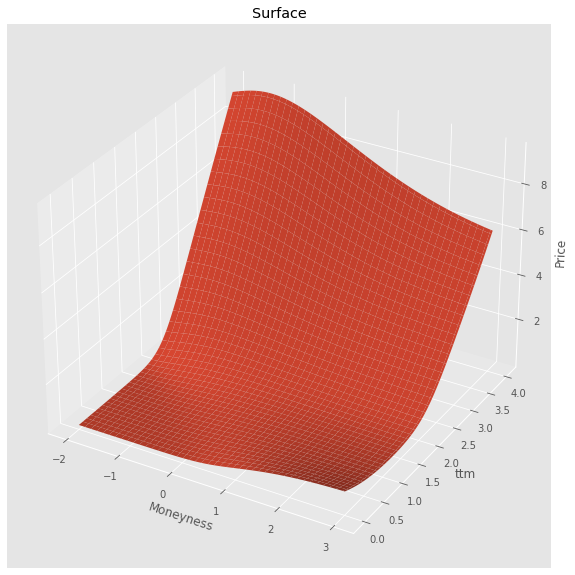

In [22]:
"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128) 
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
X2 = np.zeros((X.shape[0], N_FEATS))
X2[:, :2] = X
X2[:, 2] = 0.1
surf = (ffn(X2).numpy() + model(X2).numpy() +  gated_model([X2[:,0], X2[:,1], X2[:,2]]).numpy()) / 3
visualise_surface(SK, ts, surf)

487.71671414375305

In [39]:
all_res_df = pd.concat(all_res).T
all_res_df.loc['time', 'ensemble'] = all_res_df.T['time'].iloc[:3].sum()
all_res_df.style.background_gradient(axis = 1)

,standard_ffn,homogeneity_network,ffn+PDE,ensemble
pred_l1,0.070545,0.103332,0.122403,0.093645
pred_l2,0.140072,0.171350,0.209994,0.161240
pred_l_inf,6.760679,2.969627,3.778528,4.502944
pred_upper_bound_violation,0.260400,0.439128,0.537581,0.383301
PDE_mean,-0.028821,0.066265,0.000850,0.012764
PDE_l1,0.140571,0.233853,0.030550,0.120360
PDE_l2,0.253834,0.455530,0.053505,0.207023
PDE_l_inf,1.615682,6.545053,1.649864,1.851951
monotonicity_error,0.000000,0.000000,0.000000,0.000000
time_value_error,0.010742,0.000000,0.025098,0.003890
